In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
from torchvision import models
from torchvision import transforms
import os

In [3]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning" or os.path.split(os.getcwd())[1] == "semi-supervised" or os.path.split(os.getcwd())[1] == "self-supervised"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

Current Working Directory: progettoVIPM


In [4]:
cuda=True

In [5]:
from utils.loadersAndEnums import datasets, ImageDataset
from torch.utils.data import DataLoader, ConcatDataset, random_split

trainL = ImageDataset(dataset=datasets.TRAINING_LABELED_80,network_input_size=256, cuda=cuda, normalize=True)
trainU = ImageDataset(dataset=datasets.TRAINING_UNLABELED,network_input_size=256, cuda=cuda, normalize=True)
trainC = ConcatDataset([trainL,trainU])


In [6]:
print(len(trainC))

print(len(trainL))
print(len(trainU))

117471
4016
113455


In [7]:
train_size = int(0.8*len(trainC))
val_size = len(trainC)-train_size
train,val = random_split(trainC,[train_size,val_size])
test = ImageDataset(dataset=datasets.TEST,network_input_size=256,cuda=cuda, normalize=True)
valL = ImageDataset(dataset=datasets.VALIDATION_LABELED_20,network_input_size=256,cuda=cuda, normalize=True)

trainL = DataLoader(trainL,128,True)
train = DataLoader(train,128,True)
val = DataLoader(val,128,True)
test = DataLoader(test,128,True)
valL = DataLoader(valL,128,True)

In [8]:
from utils.sparseAutoencoder import SparseAutoencoderL1

sparseAE = SparseAutoencoderL1()

optimizer = torch.optim.Adam(sparseAE.parameters(), lr=1e-3)
criterion = nn.MSELoss()  # Reconstruction loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sparseAE.to(device)



train_loss = []
val_loss = []

num_epochs = 20
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
best_model_path = 'self-supervised/models/best_sparse_AE.pth'  # Path to save the best model

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    sparseAE.train()
    running_loss = 0.0
    print('Training:')
    i = 0
    for inputs, _ in train:
        i = i + 1
        if i % 20 == 0:
            print(f'Batch {i} di {len(train)}')
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = sparseAE(inputs)
        loss = criterion(outputs, inputs)
        loss = loss + sparseAE.sparsity_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_epoch = running_loss / len(train)
    print(f'Train_Loss: {train_loss_epoch}')
    train_loss.append(train_loss_epoch)
    
    sparseAE.eval()
    running_loss = 0.0
    print('Validation:')
    i = 0
    for inputs, _ in val:
        i = i + 1
        if i % 20 == 0:
            print(f'Batch {i} di {len(val)}')
        inputs = inputs.to(device)
        outputs = sparseAE(inputs)
        loss = criterion(outputs, inputs)
        loss = loss + sparseAE.sparsity_loss
        running_loss += loss.item()
    val_loss_epoch = running_loss / len(val)
    print(f'Validation_Loss: {val_loss_epoch}')
    val_loss.append(val_loss_epoch)

    # Save the model if the validation loss improves
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(sparseAE.state_dict(), best_model_path)
        print(f'Best model saved with validation loss: {best_val_loss}')

Epoch 1
Training:
Batch 20 di 735
Batch 40 di 735
Batch 60 di 735
Batch 80 di 735
Batch 100 di 735
Batch 120 di 735
Batch 140 di 735
Batch 160 di 735
Batch 180 di 735
Batch 200 di 735
Batch 220 di 735
Batch 240 di 735
Batch 260 di 735
Batch 280 di 735
Batch 300 di 735
Batch 320 di 735
Batch 340 di 735
Batch 360 di 735
Batch 380 di 735
Batch 400 di 735
Batch 420 di 735
Batch 440 di 735
Batch 460 di 735
Batch 480 di 735
Batch 500 di 735
Batch 520 di 735
Batch 540 di 735
Batch 560 di 735
Batch 580 di 735
Batch 600 di 735
Batch 620 di 735
Batch 640 di 735
Batch 660 di 735
Batch 680 di 735
Batch 700 di 735
Batch 720 di 735
Train_Loss: 0.028308149036907013
Validation:
Batch 20 di 184
Batch 40 di 184
Batch 60 di 184
Batch 80 di 184
Batch 100 di 184
Batch 120 di 184
Batch 140 di 184
Batch 160 di 184
Batch 180 di 184
Validation_Loss: 0.018979959807399173
Best model saved with validation loss: 0.018979959807399173
Epoch 2
Training:
Batch 20 di 735
Batch 40 di 735
Batch 60 di 735
Batch 80 di 735


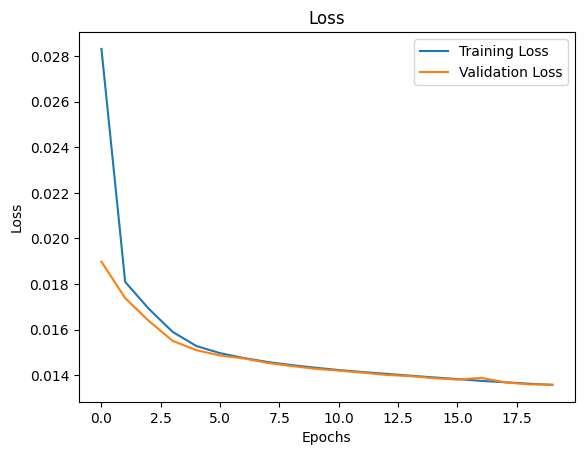

In [9]:
def plot_loss(train_loss,val_loss):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Loss')
    ax.plot(train_loss, label='Training Loss')
    ax.plot(val_loss, label='Validation Loss')
    ax.legend()

    plt.show()
    
plot_loss(train_loss,val_loss)

In [12]:
def show_image(image):
    """
    Function to display an image using matplotlib.pyplot
    :param image: Input image (numpy array or torch tensor)
    """
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    
def show_reconstruction(model, dataloader):
    """
    Function to display the original and reconstructed images
    :param model: Sparse Autoencoder model
    :param dataloader: DataLoader containing the images
    """
    model.eval()
    for i, (inputs, _) in enumerate(dataloader):
        if i >= 4:
            break
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        show_image(inputs[0])
        show_image(outputs[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11072458..1.0473211].


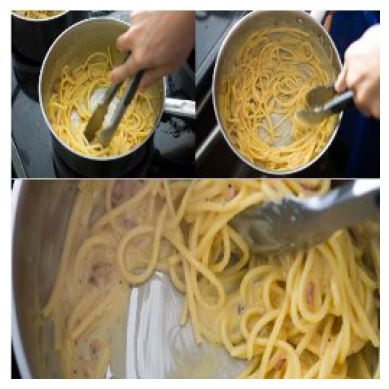

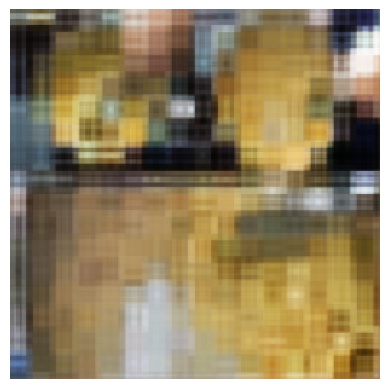

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08570582..1.1107559].


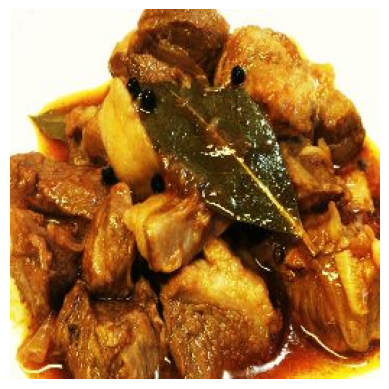

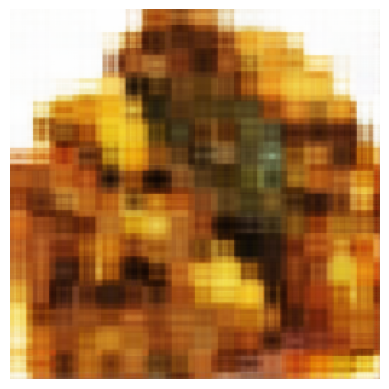

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.067156866..1.0303922].


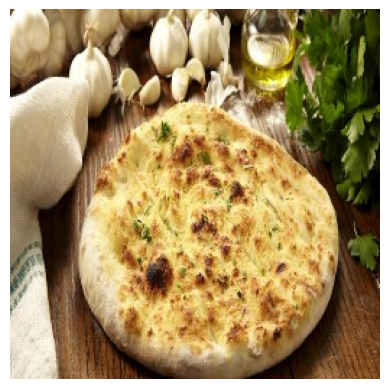

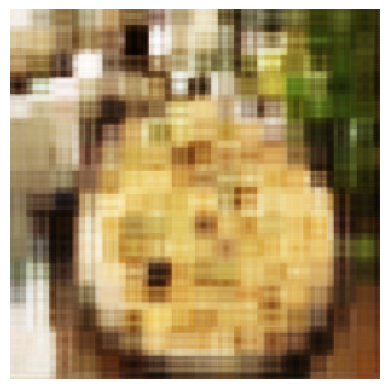

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06383353..1.0206378].


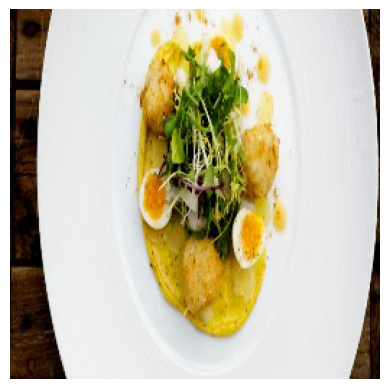

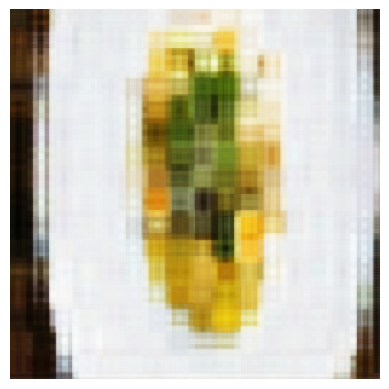

In [13]:
show_reconstruction(sparseAE, val)

In [14]:
print(sparseAE.sparsity_loss)

tensor(1.7416e-05, device='cuda:0')


In [15]:
for epoch in range(num_epochs, 2*num_epochs):
    print(f'Epoch {epoch+1}')
    sparseAE.train()
    running_loss = 0.0
    print('Training:')
    i = 0
    for inputs, _ in train:
        i = i + 1
        if i % 20 == 0:
            print(f'Batch {i} di {len(train)}')
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = sparseAE(inputs)
        loss = criterion(outputs, inputs)
        loss = loss + sparseAE.sparsity_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_epoch = running_loss / len(train)
    print(f'Train_Loss: {train_loss_epoch}')
    train_loss.append(train_loss_epoch)
    
    sparseAE.eval()
    running_loss = 0.0
    print('Validation:')
    i = 0
    for inputs, _ in val:
        i = i + 1
        if i % 20 == 0:
            print(f'Batch {i} di {len(val)}')
        inputs = inputs.to(device)
        outputs = sparseAE(inputs)
        loss = criterion(outputs, inputs)
        loss = loss + sparseAE.sparsity_loss
        running_loss += loss.item()
    val_loss_epoch = running_loss / len(val)
    print(f'Validation_Loss: {val_loss_epoch}')
    val_loss.append(val_loss_epoch)

    # Save the model if the validation loss improves
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(sparseAE.state_dict(), best_model_path)
        print(f'Best model saved with validation loss: {best_val_loss}')

Epoch 21
Training:
Batch 20 di 735
Batch 40 di 735
Batch 60 di 735
Batch 80 di 735
Batch 100 di 735
Batch 120 di 735
Batch 140 di 735
Batch 160 di 735
Batch 180 di 735
Batch 200 di 735
Batch 220 di 735
Batch 240 di 735
Batch 260 di 735
Batch 280 di 735
Batch 300 di 735
Batch 320 di 735
Batch 340 di 735
Batch 360 di 735
Batch 380 di 735
Batch 400 di 735
Batch 420 di 735
Batch 440 di 735
Batch 460 di 735
Batch 480 di 735
Batch 500 di 735
Batch 520 di 735
Batch 540 di 735
Batch 560 di 735
Batch 580 di 735
Batch 600 di 735
Batch 620 di 735
Batch 640 di 735
Batch 660 di 735
Batch 680 di 735
Batch 700 di 735
Batch 720 di 735
Train_Loss: 0.013518220945229741
Validation:
Batch 20 di 184
Batch 40 di 184
Batch 60 di 184
Batch 80 di 184
Batch 100 di 184
Batch 120 di 184
Batch 140 di 184
Batch 160 di 184
Batch 180 di 184
Validation_Loss: 0.013517445282322233
Best model saved with validation loss: 0.013517445282322233
Epoch 22
Training:
Batch 20 di 735
Batch 40 di 735
Batch 60 di 735
Batch 80 di 73

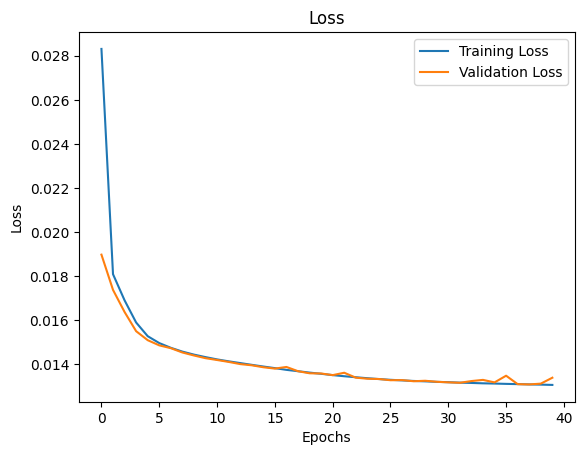

In [16]:
plot_loss(train_loss,val_loss)

In [17]:
sparseAE.load_state_dict(torch.load(best_model_path))
sparseAE.eval()  # Set the model to evaluation mode

SparseAutoencoderL1(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): Sigmoid()
  )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04360316..1.0763897].


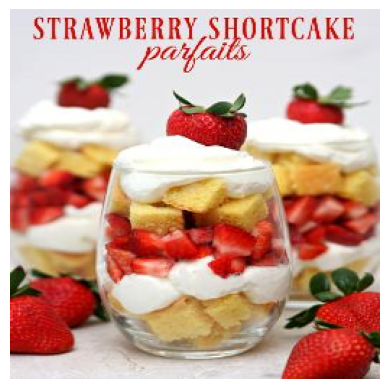

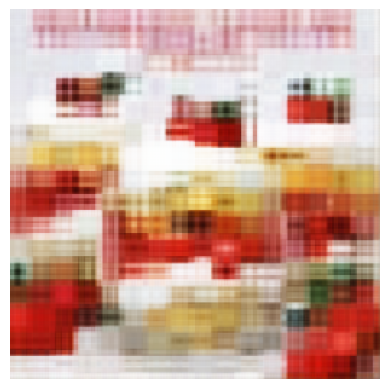

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09753635..1.1014743].


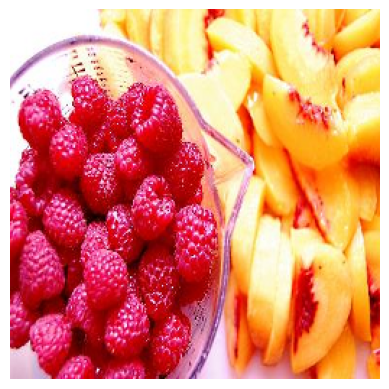

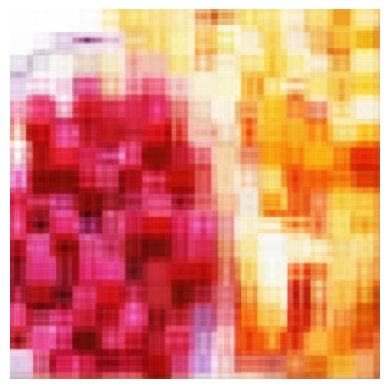

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024352528..1.0690951].


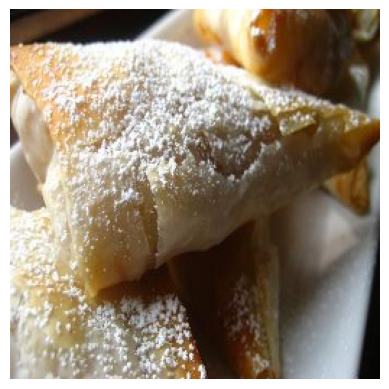

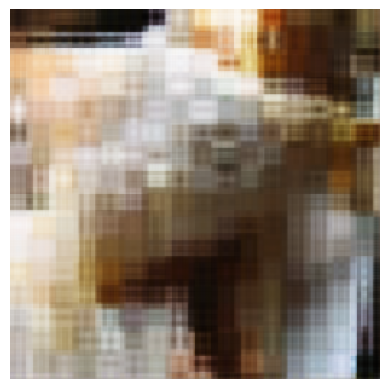

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.033866737..1.0363332].


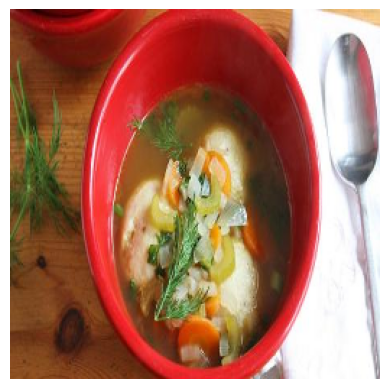

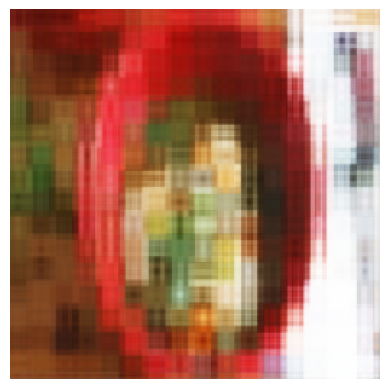

In [18]:
show_reconstruction(sparseAE, val)

In [36]:
best_model_path = 'self-supervised/models/best_sparse_AE.pth'

sparseAE.load_state_dict(torch.load(best_model_path))
sparseAE.eval()  # Set the model to evaluation mode

SparseAutoencoderL1(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): Sigmoid()
  )
)

In [38]:
class ExtendedEncoderV2(nn.Module):
    def __init__(self, base_encoder):
        super(ExtendedEncoderV2, self).__init__()
        self.base_encoder = base_encoder

        # Additional convolutional and ReLU layers
        self.additional_conv = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.additional_relu = nn.ReLU()

        # Dynamically compute flatten_dim
        dummy_input = torch.randn(1, 3, 256, 256).to(device)  # Simulate input
        self.additional_conv.to(device)  # Move additional_conv to the same device
        dummy_output = self.base_encoder(dummy_input)  # Get encoder output
        dummy_output = self.additional_conv(dummy_output)  # Pass through additional conv layer
        dummy_output = self.additional_relu(dummy_output)  # Pass through additional ReLU layer
        self.flatten_dim = dummy_output.view(1, -1).size(1)  # Flatten dimension

        # Fully connected layers with dropout
        self.fc1 = nn.Linear(self.flatten_dim, 260)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(260, 251)
        self.dropout2 = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim=1)

        # Freeze base encoder weights
        for param in self.base_encoder.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.base_encoder(x)  # Base encoder
        x = self.additional_conv(x)  # Additional conv layer
        x = self.additional_relu(x)  # Additional ReLU layer
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)  # Fully connected layer
        x = self.relu(x)  # ReLU activation
        x = self.dropout1(x)  # Dropout
        x = self.fc2(x)  # Fully connected layer
        x = self.dropout2(x)  # Dropout
        x = self.softmax(x)  # Softmax activation
        return x

In [43]:
exEncoder = ExtendedEncoderV2(sparseAE.encoder)
exEncoder.to(device)
train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 100
best_val_loss = float('inf')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(exEncoder.parameters(), lr = 1e-5)
best_model_path = 'self-supervised/models/best_AE_classifier.pth'
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}')
    exEncoder.train()
    running_loss = 0.0
    correct = 0
    total = 0
    i = 0
    print("Training:")
    for inputs, labels in trainL:
        i=i+1
        if i%10 == 0:
            print(f'Batch {i} di {len(trainL)}')
        labels = [int(label) for label in labels]
        
        inputs = inputs.to(device) 
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = exEncoder(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Training Loss: {running_loss/len(trainL)}, Accuracy: {100*correct/total}%')
    train_acc.append(100*correct/total)
    train_loss.append(running_loss/len(trainL))
    print('Validation:')
    exEncoder.eval()
    running_loss = 0.0
    i = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs,labels in valL:
            i+=1
            if i%10 == 0:
                print(f'Batch {i} di {len(valL)}')            
            labels=[int(lable) for lable in labels]
            inputs,labels = inputs.to(device), torch.tensor(labels,dtype=torch.long).to(device)
            outputs = exEncoder(inputs)
            _,predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs,labels)
            running_loss += loss.item()
    val_loss_epoch = running_loss / len(valL)
    print(f'Validation Loss: {val_loss_epoch}, Accuracy: {100*correct/total}%')
    val_loss.append(running_loss/len(valL))
    val_acc.append(100*correct/total)
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(exEncoder.state_dict(), best_model_path)
        print(f'Best model saved with validation loss: {best_val_loss}')

Epoch: 1
Training:
Batch 10 di 32
Batch 20 di 32
Batch 30 di 32
Training Loss: 5.525459706783295, Accuracy: 0.42330677290836655%
Validation:
Validation Loss: 5.525452733039856, Accuracy: 0.49800796812749004%
Best model saved with validation loss: 5.525452733039856
Epoch: 2
Training:
Batch 10 di 32
Batch 20 di 32
Batch 30 di 32
Training Loss: 5.525439456105232, Accuracy: 0.448207171314741%
Validation:
Validation Loss: 5.52544903755188, Accuracy: 0.398406374501992%
Best model saved with validation loss: 5.52544903755188
Epoch: 3
Training:
Batch 10 di 32
Batch 20 di 32
Batch 30 di 32
Training Loss: 5.525425478816032, Accuracy: 0.5229083665338645%
Validation:
Validation Loss: 5.525443613529205, Accuracy: 0.398406374501992%
Best model saved with validation loss: 5.525443613529205
Epoch: 4
Training:
Batch 10 di 32
Batch 20 di 32
Batch 30 di 32
Training Loss: 5.525413200259209, Accuracy: 0.49800796812749004%
Validation:
Validation Loss: 5.525444507598877, Accuracy: 0.398406374501992%
Epoch: 5

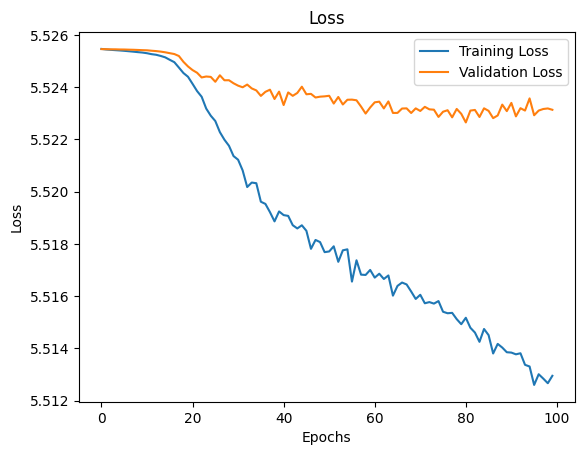

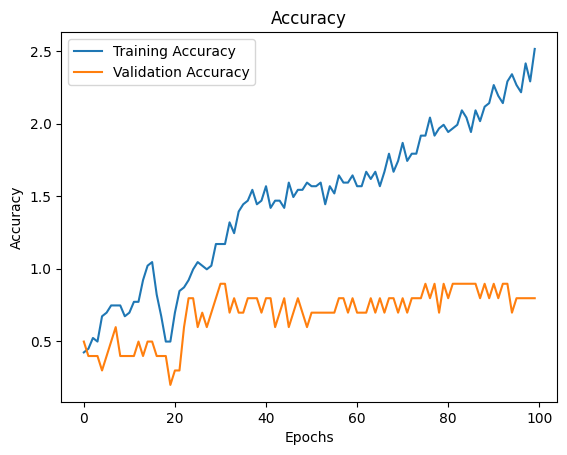

In [44]:
plot_loss(train_loss,val_loss)
def plot_accuracy(train_acc,val_acc):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy')
    ax.plot(train_acc, label='Training Accuracy')
    ax.plot(val_acc, label='Validation Accuracy')
    ax.legend()

    plt.show()
plot_accuracy(train_acc,val_acc)